# Recognition parameterized models

We consider latent variable models of the form:
$$
P(x) = \int_{z}P(x|z)P(z)
$$
where $z$ is unobserved. 

To learn such a model from data $\mathcal{D} = \{x_{1:N}\}$, one could parameterize $P_{\theta}(x|z)$ with parameters $\theta$ and maximize the variable lower bound (ELBO):
$$
L(\theta, Q) = \mathbb{E}_{x \sim \mathcal{D}, z \sim Q(\cdot|x)}[\log P_{\theta}(x|z)] - \mathbb{E}_{x \sim \mathcal{D}}KL[Q(z|x)P(x)]
$$
where $Q(z|x)$ is an approximate posterior distribution. 

In order to avoid modeling $P(x|z)$, for example because $x$ is high dimensional, have distracting signals, or that $P(x|z)$ is prone to misspecification, we can use a class of semi-parametric models that are jointly defined by a function $f(x, z)$ and the empirical data distribution $\hat{P}(x) = \frac{1}{N}\sum_{i}\delta(x - x_i)$ as:
$$
P_{f}(x|z) = \frac{\hat{P}(x)e^{f(x, z)}}{F_{f}(z)}, \quad F_{f}(z) = \int_{x}\hat{P}(x)e^{f(x, z)}
$$
This model is also referred to as the energy-based or recognition-parameterized model.

Using this model, the first term in the ELBO becomes:
$$
\begin{align*}
\mathbb{E}_{x \sim \mathcal{D}, z \sim Q(\cdot|x)}[\log P_{f}(x|z)] &= \mathbb{E}_{x \sim \mathcal{D}, z \sim Q(\cdot|x)}[f(x, z) - \log\int_{x'}\hat{P}(x')e^{f(x', z)}] + C \\
&= \mathbb{E}_{x \sim \mathcal{D}, z \sim Q(\cdot|x)}[f(x, z) - \log\mathbb{E}_{\hat{P}(x')}[e^{f(x'_{i}, z)}]] + C \\
&\approx \mathbb{E}_{x \sim \mathcal{D}, z \sim Q(\cdot|x)}[f(x, z) - \log\frac{1}{B}\sum_{i=1}^{B}e^{f(x'_{i}, z)}] + C \\
&= \mathbb{E}_{x \sim \mathcal{D}, z \sim Q(\cdot|x)}[f(x, z) - \log\sum_{i=1}^{B}e^{f(x'_{i}, z)}] + \log B + C \\
&= \mathbb{E}_{x \sim \mathcal{D}, z \sim Q(\cdot|x)}[\log\frac{e^{f(x, z)}}{\sum_{i=1}^{B}e^{f(x'_{i}, z)}}] + \log B + C \\
\end{align*}
$$
where $C = \mathbb{E}_{\hat{P}}[\log \hat{P}(x)]$, $B$ is the batch size of the negative samples. Notice the first term in the last line is a classification loss, where we try to classify positive samples from the batch of negative examples.

If we have discrete latent variables, then we can compute the posterior in closed form:
$$
\begin{align*}
Q(z|x) &\propto \exp\left(\log\frac{e^{f(x, z)}}{\sum_{i=1}^{B}e^{f(x'_{i}, z)}} + \log P(z)\right) \\
&\propto \exp\left(f(x, z) - \log \sum_{i=1}^{B}e^{f(x'_{i}, z)} + \log P(z)\right)
\end{align*}
$$
where we have to compute $f(x, z)$ for each $z$, but the denominator can be computed only once and shared for all samples. 

One particular choice one can make about the energy function is to set it to the log likelihood of a probability distribution $f(x, z) = \log P(z|x)$. The log likelihood by itself can be written in terms of an energy function: $\log P(z|x) = f(x, z) - \log \sum_{z'}\exp(f(x, z')) = f(x, z) - \log Z(x)$. 

Plugging into the ELBO and ignoring the expectation, we have:
\begin{align*}
\log\frac{e^{f(x, z)}}{\sum_{i=1}^{B}e^{f(x'_{i}, z)}} &= \log\frac{e^{\log P(z|x)}}{\sum_{i=1}^{B}e^{\log P(z|x'_{i})}} \\
&= \log\frac{e^{f(x, z) - \log Z(x)}}{\sum_{i=1}^{B}e^{f(x'_{i}, z) - \log Z(x')}} \\
\end{align*}
Since $Z(x')$ is potentially different for each $x'$, the parameterizations are equal in general.

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.distributions as torch_dist
import torch.nn as nn
import torch.nn.functional as F

seed = 0
eps = 1e-6

font_size = 14
strip_size = 12

plt.rc('font', size=font_size)            # controls default text sizes
plt.rc('axes', titlesize=font_size)       # fontsize of the axes title
plt.rc('axes', labelsize=strip_size)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=strip_size)       # fontsize of the tick labels
plt.rc('ytick', labelsize=strip_size)       # fontsize of the tick labels
plt.rc('legend', fontsize=strip_size)       # legend fontsize

In [12]:
def sample_gaussian_mixture(num_samples, num_components):
    z = torch.randn(num_samples, 2)
    scale = 4
    sq2 = 1/np.sqrt(2)

    if num_components == 8:
        centers = [(1,0), (-1,0), (0,1), (0,-1), (sq2,sq2), (-sq2,sq2), (sq2,-sq2), (-sq2,-sq2)]
    else:
        centers = [(sq2,sq2), (-sq2,sq2), (sq2,-sq2), (-sq2,-sq2)]
    centers = torch.tensor([(scale * x, scale * y) for x,y in centers])
    return sq2 * (0.5 * z + centers[torch.randint(len(centers), size=(num_samples,))])

In [328]:
torch.manual_seed(seed)

num_samples = 3000
x = sample_gaussian_mixture(num_samples, num_components=8).to(torch.float32)

# normalize
x -= x.mean(dim=0)
x /= x.std(dim=0)

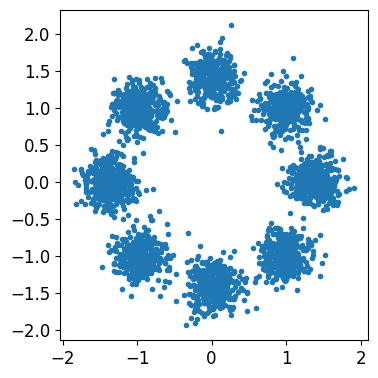

In [18]:
# plot data
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(x[:, 0], x[:, 1], ".")
plt.tight_layout()
plt.show()

In [609]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.SiLU(inplace=True))
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(nn.SiLU(inplace=True))
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class CategoricalEncoder(MLP):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__(input_dim, output_dim, hidden_dims)

    def forward(self, x):
        """Compute categorical log prob"""
        return F.log_softmax(self.network(x), dim=-1)
    
    def encode(self, x, tau=1.):
        return torch.softmax(tau * self.network(x), dim=-1)
    
class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.mlp = MLP(input_dim, output_dim * 2, hidden_dims)
    
    def forward(self, x):
        mu, ls = torch.chunk(self.mlp(x), 2, dim=-1)
        sd = ls.exp().clip(0.3)
        return mu, sd
    
    def encode(self, x):
        mu, sd = self.forward(x)
        return torch_dist.Normal(mu, sd)

In [6]:
def cross_entropy(p, q, eps=1e-6):
    logq = torch.log(q + eps)
    ce = -torch.sum(p * logq, dim=-1)
    return ce

def print_grads(model):
    for n, p in model.named_parameters():
        if p is None:
            print(n, None)
        else:
            print(n, p.grad.data.norm())

In [242]:
def train(model, data, batch_size, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    bar = tqdm(range(epochs))
    for e in bar:
        sample_idx = torch.randint(len(data), size=(batch_size,))
        x_batch = data[sample_idx]
        loss = model.compute_loss(x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_description(f"e: {e}, loss: {loss:.2f}")
        history.append(loss.data.item())
    return history

def plot_history(history):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(history)
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    plt.tight_layout()
    plt.show()

def plot_decision_boundary(model, x_lim, y_lim, ax, num_steps=100):
    x = np.linspace(x_lim[0], x_lim[1], num_steps)
    y = np.linspace(y_lim[0], y_lim[1], num_steps)
    X, Y = np.meshgrid(x, y)
    inputs = torch.from_numpy(np.stack([X, Y], axis=-1)).to(torch.float32)
    with torch.no_grad():
        Z = model.encode(inputs).argmax(-1)
    
    p = ax.contourf(X, Y, Z,)
    ax.set_title("decision boundary")
    return p

def plot_prediction(model, x, ax):
    with torch.no_grad():
        z_pred = model.encode(x)
    
    ax.scatter(x[:, 0], x[:, 1], c=z_pred.argmax(-1))
    ax.set_title("z")

def plot_confidence(model, x, ax):
    with torch.no_grad():
        z_conf = model.encode(x)
    
    ax.scatter(x[:, 0], x[:, 1], c=z_conf.max(-1)[0])
    ax.set_title("P(z)")

In [257]:
class RPM(nn.Module):
    """Recognition parameterized model"""
    def __init__(self, x_dim, z_dim, hidden_dims, energy_func="f", use_encoder=False):
        super().__init__()
        self.use_encoder = use_encoder

        if energy_func == "f":
            self.f = MLP(x_dim, z_dim, hidden_dims)
        elif energy_func == "logp":
            self.f = CategoricalEncoder(x_dim, z_dim, hidden_dims)
        else:
            raise ValueError("energy_func must be in [f, logp]")
        
        if use_encoder:
            self.encoder = CategoricalEncoder(x_dim, z_dim, hidden_dims)
    
    def forward(self, x, remove_self=False):
        """Compute log likelihood up to a constant for a batch"""
        f = self.f(x)
        if remove_self:
            f_neg = f.unsqueeze(-2).tile((1, len(x), 1))
            f_neg -= torch.eye(len(x)).unsqueeze(-1) * 1e6
        else:
            f_neg = f
        
        # lse = torch.logsumexp(f_neg - np.log(len(x)), dim=0)
        lse = torch.logsumexp(f_neg, dim=0)
        logp = f - lse
        return logp
    
    def encode(self, x):
        """Compute closed-form posterior for a batch"""
        if self.use_encoder:
            post = self.encoder.encode(x, tau=1)
        else:
            logp = self.forward(x)
            post = torch.softmax(logp, dim=-1)
        return post
    
    def compute_loss(self, x):
        """ELBO loss with closed form posterior inference"""
        # e step
        post = self.encode(x)
        ent = cross_entropy(post, post)
        
        # m step
        logp = self.forward(x)
        loss = torch.sum(post * logp, dim=-1).mean() + 0.2 * ent.mean()
        return -loss

### Discrete closed form

In [261]:
np.random.seed(0)
torch.manual_seed(0)

x_dim = x.shape[-1]
z_dim = 8
hidden_dims = [200, 200]
rpm = RPM(x_dim, z_dim, hidden_dims, energy_func="f", use_encoder=False)

batch_size = 500
lr = 1e-3
epochs = 200
history = train(rpm, x, batch_size, epochs, lr)

e: 199, loss: 4.18: 100%|██████████| 200/200 [00:00<00:00, 225.43it/s]


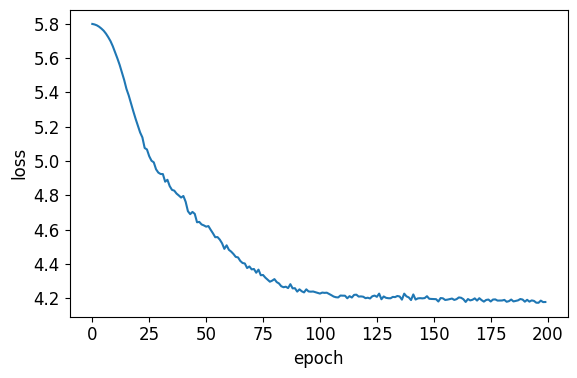

In [262]:
plot_history(history)

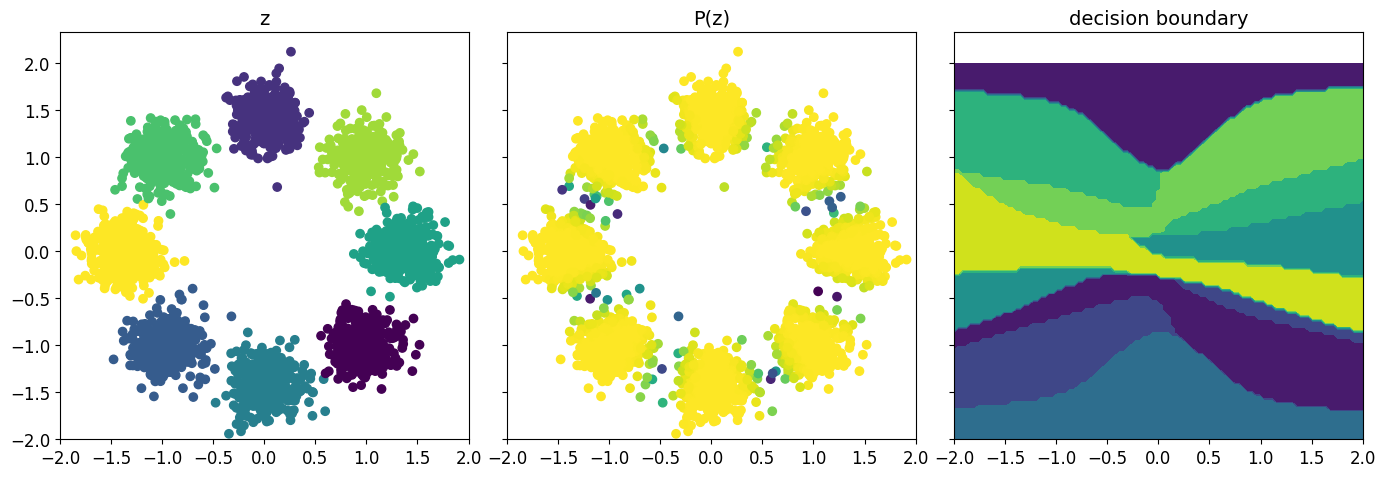

In [263]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharex=True, sharey=True)
plot_prediction(rpm, x, ax[0])
plot_confidence(rpm, x, ax[1])
plot_decision_boundary(rpm, [-2, 2], [-2, 2], ax[2])
plt.tight_layout()
plt.show()

### Discrete encoder

In [258]:
np.random.seed(0)
torch.manual_seed(0)

x_dim = x.shape[-1]
z_dim = 8
hidden_dims = [200, 200]
rpm = RPM(x_dim, z_dim, hidden_dims, energy_func="f", use_encoder=True)

batch_size = 500
lr = 1e-3
epochs = 200
history = train(rpm, x, batch_size, epochs, lr)

e: 199, loss: 4.17: 100%|██████████| 200/200 [00:00<00:00, 212.92it/s]


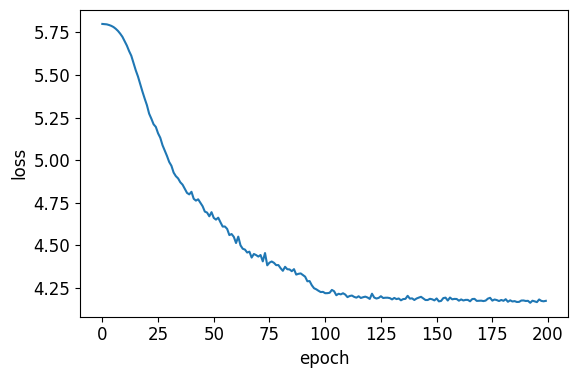

In [259]:
plot_history(history)

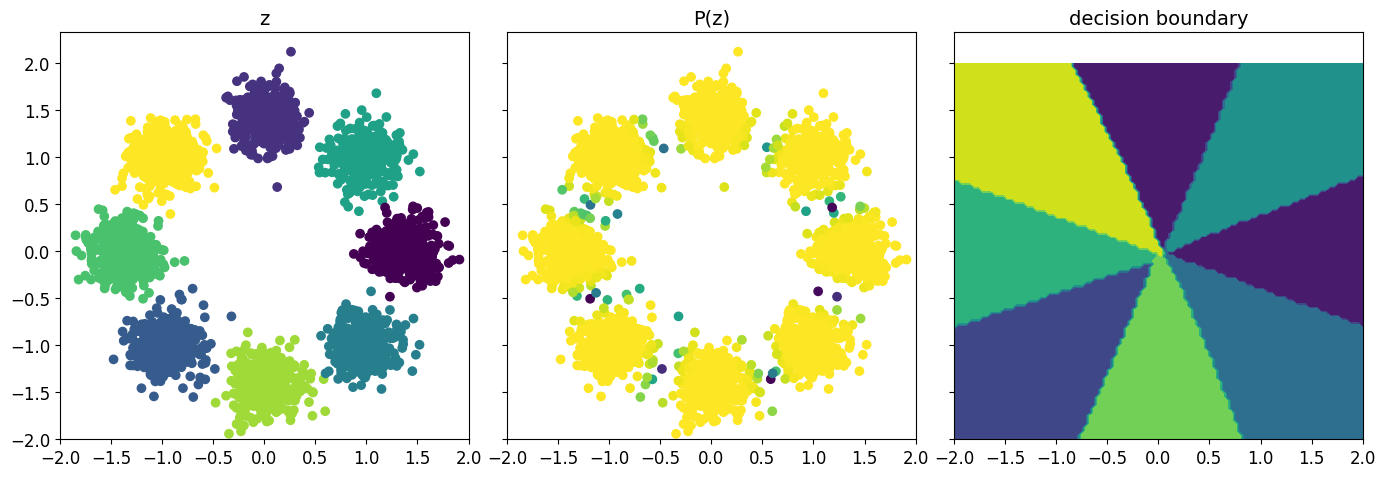

In [260]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharex=True, sharey=True)
plot_prediction(rpm, x, ax[0])
plot_confidence(rpm, x, ax[1])
plot_decision_boundary(rpm, [-2, 2], [-2, 2], ax[2])
plt.tight_layout()
plt.show()

### Continuous encoder

In [683]:
class RPMCont(nn.Module):
    """Continuous recognition parameterized model"""
    def __init__(self, x_dim, z_dim, hidden_dims, energy_func="f"):
        super().__init__()
        self.energy_func = energy_func
        if energy_func == "f":
            self.f = MLP(x_dim + z_dim, 1, hidden_dims)
        elif energy_func == "logp":
            self.f = GaussianEncoder(x_dim, z_dim, hidden_dims)
            # self.f = MLP(x_dim, z_dim, hidden_dims)
        
        self.encoder = GaussianEncoder(x_dim, z_dim, hidden_dims)
    
    def forward_f(self, x, z):
        f = self.f(torch.cat([x, z], dim=-1))

        sample_idx_neg = torch.randint(len(x), size=(50,)) # hard code number of negative samples
        x_neg = x[sample_idx_neg]
        x_neg_ = x_neg.unsqueeze(0).repeat_interleave(len(x), dim=0)
        z_ = z.unsqueeze(1).repeat_interleave(len(x_neg), dim=1)
        f_neg_ = self.f(torch.cat([x_neg_, z_], dim=-1))
        f_neg_ = torch.cat([f.unsqueeze(-2), f_neg_], dim=-2)
        
        lse = torch.logsumexp(f_neg_, dim=-2)
        logp = f - lse

        # labels = torch.zeros_like(f_neg_)
        # labels[:, 0] = 1
        # p = torch.softmax(f_neg_.squeeze(-1), dim=-1)
        # logp = -cross_entropy(labels, p)
        return logp
    
    def forward_logp(self, x, z):
        z_dist = self.f.encode(x)
        # z_dist = torch_dist.Normal(self.f(x), torch.ones(1))

        f = z_dist.log_prob(z).sum(-1)
        f_neg = z_dist.log_prob(z.unsqueeze(-2)).sum(-1)
        
        lse = torch.logsumexp(f_neg, dim=-1)
        logp = f - lse

        # labels = torch.eye(len(x))
        # p = torch.softmax(f_neg, dim=-1)
        # logp = -cross_entropy(labels, p)
        return logp
    
    def forward(self, x, z):
        """Compute log likelihood up to a constant for a batch"""
        if self.energy_func == "f":
            logp = self.forward_f(x, z)
        elif self.energy_func == "logp":
            logp = self.forward_logp(x, z)
        return logp
    
    def encode(self, x):
        mu, sd = self.encoder.forward(x)
        # mu = F.elu(mu) + 1
        # mu = torch.tanh(mu) * 10
        post = torch_dist.Normal(mu, sd)
        return post
    
    def compute_loss(self, x):
        """ELBO loss"""
        # e step
        post = self.encode(x)
        z = post.rsample()
        ent = post.entropy().sum(-1)
        
        # m step
        log_prior = torch_dist.Normal(torch.zeros(1), torch.ones(1)).log_prob(z).sum(-1)
        logp = self.forward(x, z)
        loss = logp.mean() + 0.5 * log_prior.mean() + 0.3 * ent.mean()
        return -loss

In [404]:
def train_cont(model, data, batch_size, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    bar = tqdm(range(epochs))
    for e in bar:
        sample_idx = torch.randint(len(data), size=(batch_size,))
        x_batch = data[sample_idx]
        loss = model.compute_loss(x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_description(f"e: {e}, loss: {loss:.2f}")
        history.append(loss.data.item())
    return history

In [684]:
np.random.seed(0)
torch.manual_seed(0)

x_dim = x.shape[-1]
z_dim = 4
hidden_dims = [200, 200]
rpm = RPMCont(x_dim, z_dim, hidden_dims, energy_func="logp")

batch_size = 200
lr = 1.e-3
epochs = 300
history = train_cont(rpm, x, batch_size, epochs, lr)

e: 299, loss: 4.89: 100%|██████████| 300/300 [00:01<00:00, 177.00it/s]


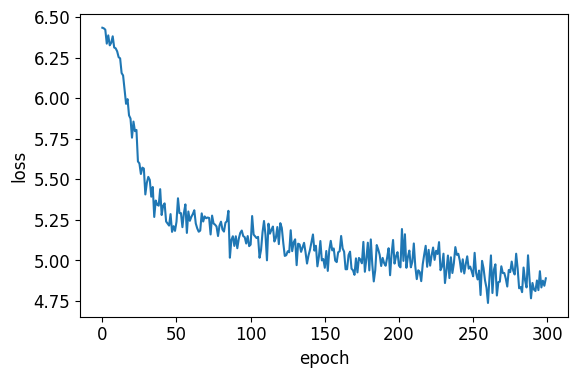

In [685]:
plot_history(history)

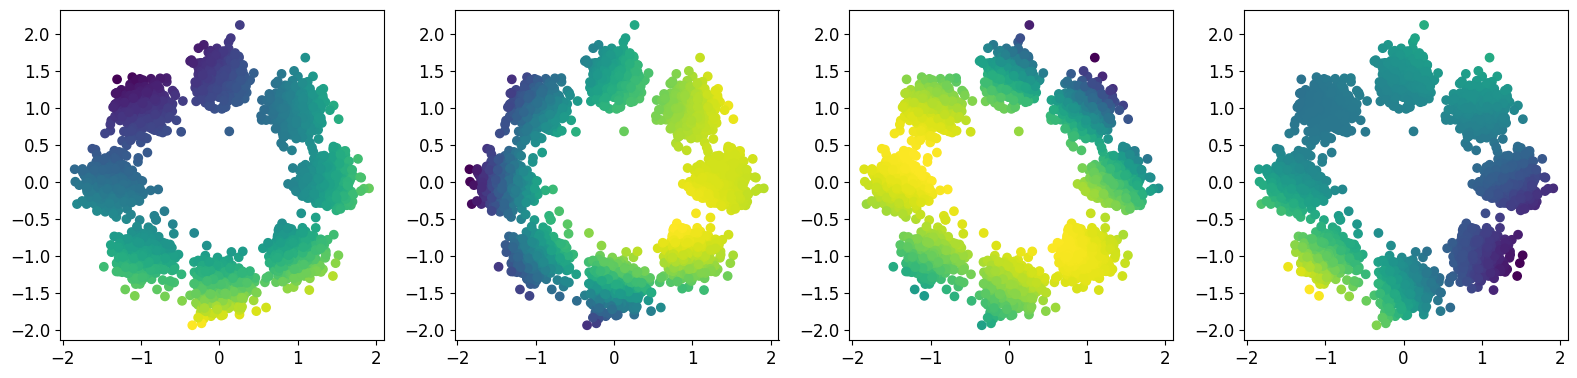

In [686]:
with torch.no_grad():
    post = rpm.encode(x)
    pred = post.mean
    conf = post.scale

num_cols = min(4, z_dim)
num_rows = np.ceil(z_dim / num_cols).astype(int)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
if isinstance(ax, np.ndarray):
    ax = ax.flat
else:
    ax = [ax]
for i in range(z_dim):
    ax[i].scatter(x[:, 0], x[:, 1], c=pred[:, i])
plt.tight_layout()
plt.show()

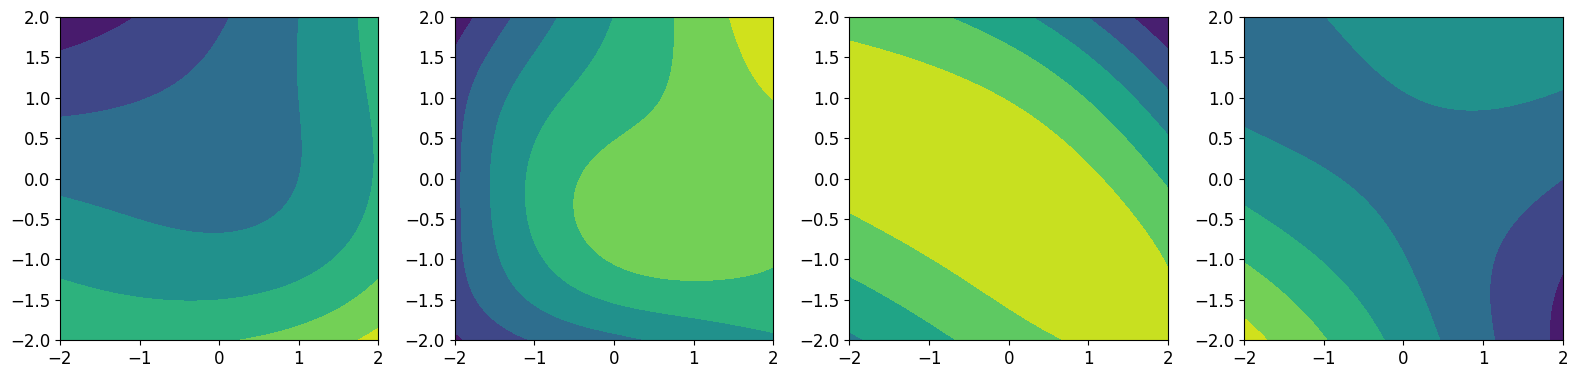

In [687]:
# def plot_contour(model, x_lim, y_lim, ax, num_steps=100):
x_lim = [-2, 2]
y_lim = [-2, 2]
num_steps = 100
x_grid = np.linspace(x_lim[0], x_lim[1], num_steps)
y_grid = np.linspace(y_lim[0], y_lim[1], num_steps)
X, Y = np.meshgrid(x_grid, y_grid)
inputs = torch.from_numpy(np.stack([X, Y], axis=-1)).to(torch.float32)
with torch.no_grad():
    post = rpm.encode(inputs)
    pred = post.mean
    conf = post.scale

num_cols = min(4, z_dim)
num_rows = np.ceil(z_dim / num_cols).astype(int)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
if isinstance(ax, np.ndarray):
    ax = ax.flat
else:
    ax = [ax]
for i in range(z_dim):
    ax[i].contourf(X, Y, pred[:, :, i],)
plt.tight_layout()
plt.show()